# Gestión Moderna de Portafolio
### Autores: Bernardo León y Carlos Zapata
### Copyright 2022

## Capitulo 13: Optimización Robusta de Portafolios


In [1]:
#Librerías usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
%pip install yfinance
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 680 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


### Ejemplo 13.1

In [3]:
# Información histórica dentro de muetsra (In-sample) para las acciones
fechai = "2015-12-01"
fechaf = "2020-12-31"
periodicidad = "1Mo"
activos = ["ADBE","MCD","MSCI","MSFT","NEE","PG","RSG","WMT"]
precios = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()

[*********************100%***********************]  8 of 8 completed


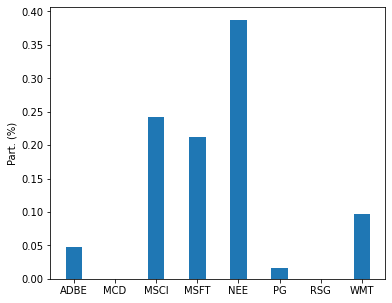

In [4]:
# PT de Sharpe
rf = 0.0
r = mu -rf 
n = len(mu)
# PT de Sharpe
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Minimize(risk)
constraints = [w @ r == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wpt = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [ ]:
# PT de Sharpe
rf = 0.0
r = mu -rf 
n = len(mu)

# PT de Sharpe
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Minimize(risk)
constraints = [w @ r == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wpt = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

### Portafolios Robustos

#### Incertidumbre de Intervalo

In [12]:
# Calculo delta (distribución normal)
from scipy.stats import norm
t = len(retornos)
alpha = 0.05
znorm = norm.ppf((1-alpha/2))
delta = znorm*sigma/np.sqrt(t)

# Calculo lambda
rpt = wpt @ mu
sigmapt = np.sqrt(wpt.T @ cov @ wpt)
lambda_coef = (rpt-rf)/sigmapt**2

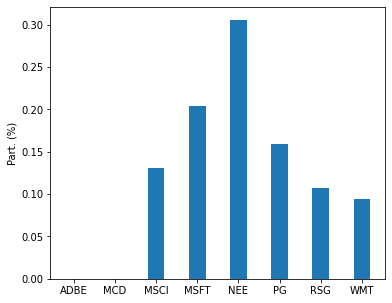

In [15]:
# PRMVi
unos = np.repeat(1,n)
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Maximize(w @ mu - w @ delta - lambda_coef*risk)
constraints = [w @ unos == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wprmvi = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wprmvi, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

#### Incertidumbre Elipsoidal

In [35]:
# Calculo delta (distribución Chi-cuadrado)
from scipy.stats import chi2
alpha = 0.05
delta2 = np.sqrt(chi2.ppf(alpha, n))

In [77]:
# PRMVi
unos = np.repeat(1,n)
S12 = pd.DataFrame(np.linalg.cholesky(cov))
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Maximize(w @ mu - lambda_coef*risk - delta2*(np.linalg.norm(S12 @ w)) )
constraints = [w @ unos == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wprmvi = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wprmvi, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [24]:
    prob <- Problem(Maximize( t(w)%*%mu-lambda*(quad_form(w, cov))-delta2*(norm2(S12%*%w))),
                    constraints = list(w >= 0, ones(1,n)%*%w==1))
    result <- solve(prob)
    return(as.vector(result$getValue(w)))
}